# MCP Tutorial with LangGraph, SGLang, and Qwen
##### This notebook is an MVP for learning and implementing a barebones MCP setup

<img src="assets/images/MCP_LangGraph_Arch.png" width=500 />

---

# 1. Imports

### The Dependencies Needed for this Notebook:
```
uv add --upgrade \
    mcp \
    sglang \
    langgraph \
    langchain-openai \
    langchain-mcp-adapters \
    jupyterlab \
    jupyterlab-nvdashboard
```

In [ ]:
# =====================================================
# === 1. imports ( 5 LOC ) ============================
# =====================================================

from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_mcp_adapters.client import MultiServerMCPClient

<br/>

# 2. MCP Server & Tools

### MCP Server

<img src="assets/images/MCP_Server.png" width=500 />

### MCP Tool

<img src="assets/images/MCP_Tool.png" width=500 />

### The MCP Server is file 006_MCP_Server.py
### The bare minimup MPC Tool Server is
```python
from mcp.server.fastmcp import FastMCP
mcp = FastMCP("stock-tools")
@mcp.tool()
def add(a: int, b: int) -> int:
    """Check if number is prime
        Args: x number of unknown primacy
        Returns: True is x is prime, otherwise false
    """
    return a + b
mcp.run(transport="sse")
```
<br/>

### It is run with this command:
  
```bash
uv run python 006_MCP_Server.py
```

<br/>

# 3. SGLang

<img src="assets/images/SGLang_Server.png" width=500 />

##### Qwen can be hosted on SGLang like so:
 ```uv run python -m sglang.launch_server --model qwen/qwen2.5-0.5B-Instructs --tool-call-parswer qwen```

<br/>

# 4. LLM 


<img src="assets/images/LLM_Qwen.png" width=500 />

### This LLM uses Qwen

In [21]:
# =====================================================
# === LLM Setup ( 1 LOC ) =============================
# =====================================================
llm = ChatOpenAI(
    model="Qwen/Qwen2.5-0.5B-Instruct",
    base_url="http://localhost:30000/v1",
    api_key="not-used",  # required by ChatOpenAI, ignored by SGLang
            
    temperature=0.1,
    max_tokens=None,
    stream_usage=True,  # Include token usage in streaming responses
)

<br/>

# 5. MCP Client

<img src="assets/images/MCP_Client.png" width=500>

In [24]:
# =====================================================
# === MCP Client ( 3 LOC ) ==========================
# =====================================================
async def get_mcp_tools():
    """Fetch MCP tools from the server."""
    client = MultiServerMCPClient(
        {
            "stock-tools": {
                "url": "http://localhost:8000/sse",
                "transport": "sse",
            }
        }
    )
    return await client.get_tools()

mcp_tools = await get_mcp_tools()

<br/>

# 6. LangGraph Agent / Node


<img src="assets/images/LangGraph_Agent.png" width=500>

### Tool-Calling Node or Agent

In [25]:
# =====================================================
# === LangGraph Agent ( 5 LOC ) =======================
# =====================================================
"""Build the LangGraph with MCP tools."""
llm_with_tools = llm.bind_tools(mcp_tools)

def tool_caller(state: MessagesState):
    """LLM for tool selection and calling."""
    system = SystemMessage(
        content="""You are a helpful assistant. Select and call the appropriate tool based on the user's request."""
    )
    messages = [system] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

<br/>

# 7. LangGraph App


<img src="assets/images/LangGraph_App.png" width=500>

### This is the app that uses all the resources

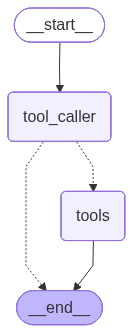

In [26]:
# =====================================================
# === Graph Builder ( 15 LOC ) ========================
# =====================================================
# def build_graph(mcp_tools):    
    
def route_after_tool_caller(state: MessagesState):
    """ Routing: tool_caller if need tool, else END """
    last_msg = state["messages"][-1]
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "tools"
    return END


# Build LangGraph Agent
graph = StateGraph(MessagesState)
graph.add_node("tool_caller", tool_caller)  # Fast local SGLang
graph.add_node("tools", ToolNode(mcp_tools))

graph.add_edge(START, "tool_caller")
graph.add_conditional_edges("tool_caller", route_after_tool_caller, ["tools", END])
graph.add_edge("tools", END)

app = graph.compile()
app

---

# Test
### Can't use 'invoke' - MCP is async, invoke() is sync
### Must use 'await' and 'ainvoke' since asynchronous

In [ ]:

result = await app.ainvoke({"messages": [HumanMessage(content="What is 2 + 2?")]})
result['messages'][-1].content

'4'

---

# Test - Detailed Output
### This is to help with debugging and understanding

In [15]:
# =====================================================
# === Streaming Tester ================================
# =====================================================

import json

# ANSI color codes
DIM_GREEN = "\033[2;32m"
YELLOW = "\033[93m"
CYAN = "\033[96m"
GRAY = "\033[38;5;241m"
MAGENTA = "\033[95m"
RESET = "\033[0m"

async def mcp_tools_invoke(prompt: str):
    """Stream agent execution with verbose output."""
    print(f'{GRAY}PROMPT: "{prompt}"{RESET}\n')
    inputs = {"messages": [HumanMessage(content=prompt)]}

    async for event in app.astream(inputs, stream_mode="updates"):
        for node_name, output in event.items():
            if node_name == "tool_caller":
                msg = output["messages"][0]
                print(f"{MAGENTA}[SGLang 14B]{RESET}")
                
                if msg.content:
                    print(f"{DIM_GREEN}{msg.content}{RESET}")
                
                if hasattr(msg, "tool_calls") and msg.tool_calls:
                    for tc in msg.tool_calls:
                        print(f"{YELLOW}[Tool Call: {tc['name']}]{RESET}")
                        print(f"Args: {tc['args']}")
                
                if hasattr(msg, "usage_metadata") and msg.usage_metadata:
                    u = msg.usage_metadata
                    print(f"{GRAY}Tokens: in={u.get('input_tokens', '?')} out={u.get('output_tokens', '?')}{RESET}")
                print()

            elif node_name == "tools":
                for msg in output["messages"]:
                    print(f"{CYAN}[Tool Result]{RESET}")
                    print(f"{DIM_GREEN}{msg.content}{RESET}")
                print()

In [16]:
await mcp_tools_invoke("What is 2 + 2?")

PROMPT: "What is 2 + 2?"

[SGLang 14B]
[Tool Call: add]
Args: {'x': 2, 'y': 2}
Tokens: in=533 out=25

[Tool Result]
4

